In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import os
import sys
from pathlib import Path
from re import match

import numpy as np
import polars as pl
import s3fs
import seaborn as sns
from hydra import compose, core, initialize
from omegaconf import OmegaConf
from sklearn.model_selection import StratifiedGroupKFold

sys.path.append(str(Path(os.getcwd()).parents[0]))
from src.transformers import (
    DateTimesFeatures,
    TransactionAmountsFeatures,
    TransactionTimesFeatures,
)

## Hydra Configurations

In [2]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(
    version_base="1.2", config_path="../src/config", job_name="feature_engineering"
)
config = OmegaConf.to_container(compose(config_name="main"), resolve=True)

hydra.initialize()

In [3]:
random_state = np.random.RandomState(config["random_seed"])

## Read in Sanitized Data 

In [10]:
data = pl.read_parquet(f"s3://{config['s3_bucket']}/data/sanitized/data.parquet")
data.head(5)

accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
str,str,f32,f32,datetime[ms],f32,str,str,str,str,str,str,date,date,date,str,str,str,str,f32,bool,bool,bool
"""737265056""","""737265056""",5000.0,5000.0,2016-08-13 14:27:32,98.550003,"""Uber""","""US""","""US""","""02""","""01""","""rideshare""",2023-06-30,2015-03-14,2015-03-14,"""414""","""414""","""1803""","""PURCHASE""",0.0,false,false,false
"""737265056""","""737265056""",5000.0,5000.0,2016-10-11 05:05:54,74.510002,"""AMC #191138""","""US""","""US""","""09""","""01""","""entertainment""",2024-02-29,2015-03-14,2015-03-14,"""486""","""486""","""767""","""PURCHASE""",0.0,true,false,false
"""737265056""","""737265056""",5000.0,5000.0,2016-11-08 09:18:39,7.47,"""Play Store""","""US""","""US""","""09""","""01""","""mobileapps""",2025-08-31,2015-03-14,2015-03-14,"""486""","""486""","""767""","""PURCHASE""",0.0,false,false,false
"""737265056""","""737265056""",5000.0,5000.0,2016-12-10 02:14:50,7.47,"""Play Store""","""US""","""US""","""09""","""01""","""mobileapps""",2025-08-31,2015-03-14,2015-03-14,"""486""","""486""","""767""","""PURCHASE""",0.0,false,false,false
"""830329091""","""830329091""",5000.0,5000.0,2016-03-24 21:04:46,71.18,"""Tim Hortons #947751""","""US""","""US""","""02""","""01""","""fastfood""",2029-10-31,2015-08-06,2015-08-06,"""885""","""885""","""3143""","""PURCHASE""",0.0,true,false,false


## Account-Level Feature Engineering

One feature-engineering technique that can be precomputed before any train-val-test split is the so-called account-level features. 

**Reference**: [Feature engineering strategies for credit card fraud detection](https://albahnsen.github.io/files/Feature%20Engineering%20Strategies%20for%20Credit%20Card%20Fraud%20Detection_published.pdf)

### Aggregating Transaction Data by Account

The `TransactionAmountFeatures` transformer implements rolling transaction features over various time windows, by grouping transactions by account ID, as well as by account ID combined with pairs of additional categorical columns.

For each transaction, this transformer computes rolling statistics (sum, median, and count) of transaction amounts within specific time windows. The windows are defined in hours: $1h$, $3h$, $6h$, $12h$, $18h$, $24h$, $72h$, and $168h$.

### Key Concepts

- **Rolling Window**: For each transaction $i$, we look backward in time by a specified period $t_p$ (e.g., $24h$) and consider all transactions from the same account (and optionally the same combination of additional grouping columns) that occurred within that period.
- **Aggregations**: The transformer computes:
  - **Count**: How many transactions occurred in the last $t_p$ hours (rolling count).
  - **Sum**: The sum of all transaction amounts in the last $t_p$ hours (rolling sum).
  - **Median**: The median of all transaction amounts in the last $t_p$ hours (rolling median).

### Mathematical Definitions

#### Aggregation by Account Only

Define the following notations:

- $\mathcal{S}$ be the entire dataset of transactions.
- Each transaction $i$ in $\mathcal{S}$ has attributes:
  - $x_i^{id}$: The account ID of transaction $i$.
  - $x_i^{time}$: The timestamp of transaction $i$.
  - $x_i^{amt}$: The amount of transaction $i$.

Define $t_p$ as the rolling time window in hours (e.g., $t_p = 24h$).

For each transaction $i$, we form the subset $\mathcal{S}_{agg}(i, t_p)$ which includes all transactions from the **same account** $x_i^{id}$ that occurred within the preceding $t_p$ hours of $x_i^{time}$. Formally, $l$ be the index of a particular transaction in $\mathcal{S}$, the subset is defined as:

$$
\begin{align*}
\mathcal{S}_{agg}(i, t_p) &= \{ x_l \in \mathcal{S} \mid x_l^{id} = x_i^{id} \wedge \text{hours between}(x_l^{time}, x_i^{time}) < t_p \}
\end{align*}
$$

Here, $\text{hours between}(t_1, t_2)$ is a function that calculates the number of hours between times $t_1$ and $t_2$. Note that the implementation is right-inclusive, meaning that the transaction $i$ itself is included in the aggregation but the start of the window $x_l^{time}$ is not.

From this subset, we derive the features:

- **Count of Transactions in Last $t_p$ Hours**:
  
  $$
  x_i^{a1} = |\mathcal{S}_{agg}(i, t_p)|
  $$

- **Sum of Transaction Amounts in Last $t_p$ Hours**:

  $$
  x_i^{a2} = \sum_{x_l \in \mathcal{S}_{agg}(i, t_p)} x_l^{amt}
  $$

- **Median of Transaction Amounts in Last $t_p$ Hours**:

  $$
  x_i^{a3} = \text{median}\{ x_l^{amt} \mid x_l \in \mathcal{S}_{agg}(i, t_p) \}
  $$

#### Aggregation by Account and Additional Grouping Columns

Next, consider that we have additional categorical columns, say `c1` and `c2`, and we wish to compute the same rolling features but only over those transactions that share both the same `account_id` and the same values for `c1` and `c2`.

For each transaction $i$:

$$
\begin{align*}
\mathcal{S}_{agg2}(i, t_p, c1, c2) &= \{ x_l \in \mathcal{S} \mid x_l^{id} = x_i^{id} \wedge x_l^{c1} = x_i^{c1} \wedge x_l^{c2} = x_i^{c2} \wedge \text{hours between}(x_l^{time}, x_i^{time}) < t_p \}
\end{align*}
$$

The features for this subset are analogous:

- Count of Transactions:

  $$
  x_i^{b1} = |\mathcal{S}_{agg2}(i, t_p, c1, c2)|
  $$

- Sum of Transaction Amounts:

  $$
  x_i^{b2} = \sum_{x_l \in \mathcal{S}_{agg2}(i, t_p, c1, c2)} x_l^{amt}
  $$

- Median of Transaction Amounts:

  $$
  x_i^{b3} = \text{median}\{ x_l^{amt} \mid x_l \in \mathcal{S}_{agg2}(i, t_p, c1, c2) \}
  $$

### Data Leakage Considerations

The key reason this feature computation is safe and does not cause data leakage is that it only uses information from the past relative to each transaction. When a new transaction occurs, the rolling window looks backward in time—up to the transaction’s own timestamp—and aggregates only the historical transactions that have already happened before it. This ensures that no future or unseen events at the time of a given transaction are influencing the features.

In a production setting, this aligns naturally with how data arrives: at the moment a transaction occurs, all the necessary historical data (previous transactions by the same account or by the same account and certain categories) is already known and can be safely used. Since these features depend solely on data available up to the transaction’s timestamp, they can be computed on-the-fly without revealing information that wouldn't have been known at that point in time. Thus, there is no introduction of information from the future into the current transaction’s features.

In [4]:
transaction_amounts_features = TransactionAmountsFeatures(
    account_id_column="accountNumber",
    transaction_datetime_column="transactionDateTime",
    transaction_amount_column="transactionAmount",
    group_by_columns=[
        "posEntryMode",
        "transactionType",
        "merchantCategoryCode",
        "merchantCountryCode",
    ],
)

data = transaction_amounts_features.fit_transform(data)

data.head(5)

accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,1hTransactionSum,1hTransactionMedian,1hTransactionCount,1hposEntryModetransactionTypeTransactionSum,1hposEntryModetransactionTypeTransactionMedian,1hposEntryModetransactionTypeTransactionCount,1hposEntryModemerchantCategoryCodeTransactionSum,1hposEntryModemerchantCategoryCodeTransactionMedian,1hposEntryModemerchantCategoryCodeTransactionCount,1hposEntryModemerchantCountryCodeTransactionSum,1hposEntryModemerchantCountryCodeTransactionMedian,1hposEntryModemerchantCountryCodeTransactionCount,1htransactionTypemerchantCategoryCodeTransactionSum,1htransactionTypemerchantCategoryCodeTransactionMedian,1htransactionTypemerchantCategoryCodeTransactionCount,1htransactionTypemerchantCountryCodeTransactionSum,1htransactionTypemerchantCountryCodeTransactionMedian,…,72hposEntryModetransactionTypeTransactionCount,72hposEntryModemerchantCategoryCodeTransactionSum,72hposEntryModemerchantCategoryCodeTransactionMedian,72hposEntryModemerchantCategoryCodeTransactionCount,72hposEntryModemerchantCountryCodeTransactionSum,72hposEntryModemerchantCountryCodeTransactionMedian,72hposEntryModemerchantCountryCodeTransactionCount,72htransactionTypemerchantCategoryCodeTransactionSum,72htransactionTypemerchantCategoryCodeTransactionMedian,72htransactionTypemerchantCategoryCodeTransactionCount,72htransactionTypemerchantCountryCodeTransactionSum,72htransactionTypemerchantCountryCodeTransactionMedian,72htransactionTypemerchantCountryCodeTransactionCount,72hmerchantCategoryCodemerchantCountryCodeTransactionSum,72hmerchantCategoryCodemerchantCountryCodeTransactionMedian,72hmerchantCategoryCodemerchantCountryCodeTransactionCount,168hTransactionSum,168hTransactionMedian,168hTransactionCount,168hposEntryModetransactionTypeTransactionSum,168hposEntryModetransactionTypeTransactionMedian,168hposEntryModetransactionTypeTransactionCount,168hposEntryModemerchantCategoryCodeTransactionSum,168hposEntryModemerchantCategoryCodeTransactionMedian,168hposEntryModemerchantCategoryCodeTransactionCount,168hposEntryModemerchantCountryCodeTransactionSum,168hposEntryModemerchantCountryCodeTransactionMedian,168hposEntryModemerchantCountryCodeTransactionCount,168htransactionTypemerchantCategoryCodeTransactionSum,168htransactionTypemerchantCategoryCodeTransactionMedian,168htransactionTypemerchantCategoryCodeTransactionCount,168htransactionTypemerchantCountryCodeTransactionSum,168htransactionTypemerchantCountryCodeTransactionMedian,168htransactionTypemerchantCountryCodeTransactionCount,168hmerchantCategoryCodemerchantCountryCodeTransactionSum,168hmerchantCategoryCodemerchantCountryCodeTransactionMedian,168hmerchantCategoryCodemerchantCountryCodeTransactionCount
str,f32,f32,datetime[ms],f32,str,str,str,str,str,date,date,date,str,str,str,f32,bool,bool,bool,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,…,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16
"""999389635""",5000.0,5000.0,2016-02-09 14:23:41,101.459999,"""US""","""US""","""05""","""01""","""online_retail""",2019-12-31,2015-10-09,2015-10-09,"""140""","""140""","""PURCHASE""",0.0,false,false,false,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,…,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1
"""999389635""",5000.0,4923.540039,2016-07-22 01:28:10,4.62,"""US""","""US""","""05""","""

Randomly sample newly engineered features and plot the scatter plot matrix:

In [5]:
data_pandas = data.to_pandas()

engineered_features = [col for col in data.columns if match(r"^\d{1,3}h", col)]

Text(0.5, 1.02, 'Pairplot of Engineered Features')

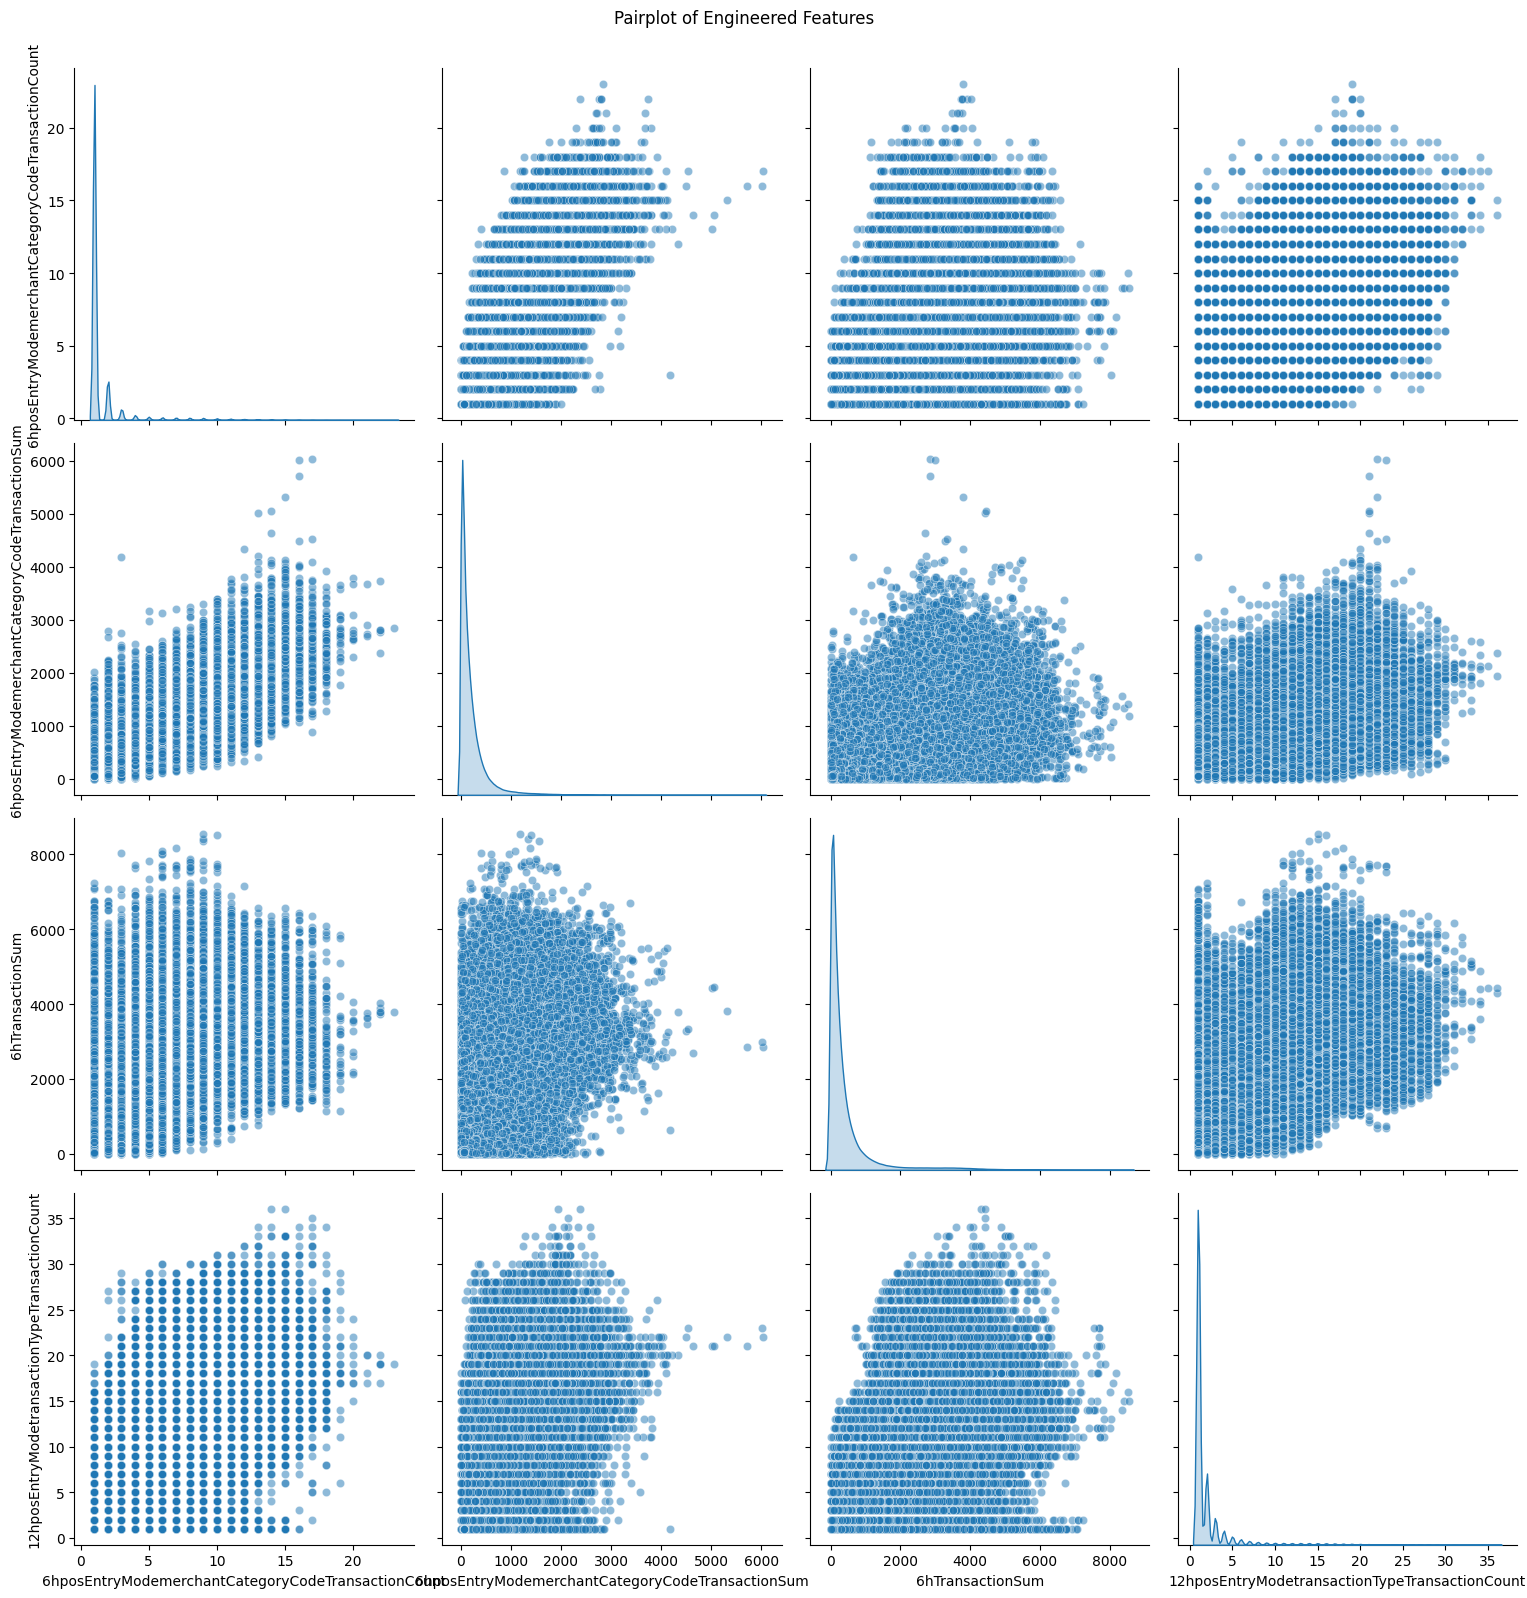

In [ ]:
selected_features = random_state.choice(engineered_features, 6, replace=False)

num_pairplot = sns.pairplot(
    data_pandas.loc[:, selected_features], diag_kind="kde", plot_kws={"alpha": 0.5}
)
num_pairplot.fig.set_size_inches(16, 16)
num_pairplot.figure.suptitle("Pairplot of Engineered Features", y=1.02)

## Transaction Times Feature Engineering

In the same reference paper, the authors also propose a feature engineering technique that models transaction times as a periodic variable. This approach captures temporal patterns in transaction behavior, such as the time of day when transactions are typically made.

The transaction times are modeled as a periodic variable using the [**von Mises distribution**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.vonmises.html). This distribution, also known as the periodic normal distribution, wraps a normally distributed variable across a circle, making it well-suited for periodic data such as transaction times within a 24-hour cycle. 

### Von Mises Distribution

Given a set of transaction times $D = \{t_1, t_2, \dots, t_N\}$, the von Mises distribution is defined as:

$$
D \sim \text{vonmises}\left(\mu, \frac{1}{\kappa}\right)
$$

where 

- $\mu$: A **measure of location** (the distribution is clustered around this direction)
- $\kappa$: A **measure of concentration** (a reciprocal measure of dispersion)

### Confidence Interval for Transaction Time

To extract features, we calculate a **confidence interval (CI)** for each transaction time. The process begins by selecting transactions from the same account in a rolling window of $t_p$ days. **Note**: The rolling window in this case is defined in days, not hours, to capture longer-term patterns in transaction times.

$$
\begin{align*}
\mathcal{S}_{\text{per}} &= \text{TRX}_{\mathrm{vM}}(\mathcal{S}, i, t_p) \\
&= \left\{x_l^{\text{time}} \mid \left(x_l^{\text{id}} = x_i^{\text{id}}\right) \wedge \left(\text{hours between}(x_i^{\text{time}}, x_l^{\text{time}}) < t_p\right) \right\}.
\end{align*}
$$

Using the selected transactions, the time of the current transaction is modeled as:

$$
x_i^{\text{time}} \sim \text{vonmises}\left(\mu(\mathcal{S}_{\text{per}}), \frac{1}{\kappa(\mathcal{S}_{\text{per}})}\right).
$$

### Feature Extraction

Based on the von Mises distribution, we compute a **binary feature** $x_i^{p1}$ indicating whether the transaction time lies within a confidence interval of the periodic distribution at a specified confidence level $\alpha$. Specifically:

- If $x_i^{\text{time}}$ falls within the CI with probability $\alpha$, $x_i^{p1} = 1$; otherwise, $x_i^{p1} = 0$.

This process is repeated for multiple rolling windows $\in \{7, 14, 30\}$ days and confidence levels $\in \{0.9, 0.95\}$ to capture temporal patterns in transaction behavior.

### Implementation Details

##### 1. **Mapping Datetimes to Radians**

Transaction times are mapped to radians $[0, 2\pi]$ to represent their periodic nature. This ensures the distribution wraps seamlessly around the clock (e.g., midnight follows 11:59 PM). The formula for conversion is:

$$
t_{\text{radians}} = \left( h + \frac{m}{60} + \frac{s}{3600} \right) \cdot \frac{2\pi}{24}
$$

Where $h, m, s$ are the hour, minute, and second of the transaction time.

##### 2. **Fitting the von Mises Distribution**

For each rolling window of transaction times, the **von Mises distribution** is fitted to compute the parameters $\mu$ and $\kappa$.

Transaction times first are converted to radians $[0, 2\pi]$ and passed to SciPy's `vonmises.fit`. 

The fitted location parameter $\mu$ is adjusted using modulo $2\pi$ for consistency, while the concentration parameter $\kappa$ remains unchanged. This adjustment is equivalent to first transforming the transaction times to $[-\pi, \pi]$, which is the range expected by SciPy's implementation of the PDF, and then passing them into `fit`. This is because the von Mises distribution is circular, and the relative differences $(x - \mu)$ remain consistent regardless of the range transformation. $\kappa$ does not need adjustment because it represents the concentration of the data and is independent of the location or range.

##### 3. **Density and Confidence Interval**

Reference

- [Fraud Detection in R](https://s3.amazonaws.com/assets.datacamp.com/production/course_8916/slides/chapter1.pdf)

- [Circular Data Analysis](https://www.ncss.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Circular_Data_Analysis.pdf)

The von Mises probability density function (PDF) for transaction times $x$ is:

$$
f(x; \kappa, \mu) = \frac{\exp(\kappa \cos(x - \mu))}{2\pi I_0(\kappa)}
$$

Where $I_0(\kappa)$ is the modified Bessel function of order zero. 

To determine if the latest transaction falls within the confidence interval (CI) of the distribution of transaction times within a window:

1. **Density at the Latest Transaction**: Compute the PDF $f(x_{\text{last}}; \kappa, \mu)$, where $x_{\text{last}}$ is the most recent transaction time.

2. **Quantile for Confidence Level \( $\alpha$ \)**: Find the cutoff quantile $q$ using the percent-point function (PPF):

   $$
   q = \text{vonmises.ppf}\left(\frac{1 - \alpha}{2}, \kappa, \text{loc}=\mu\right)
   $$

3. **Density Threshold**: Compute the density at the quantile $f(q; \kappa, \mu)$. This density represents the lower bound for the CI.

4. **Threshold Comparison**: Compare the density of the latest transaction to the threshold:

   - If $f(x_{\text{last}}) \geq f(q)$, the transaction time lies within the CI.
   - This logic ensures the density (and thus the probability) of the transaction aligns with the expected pattern under the von Mises distribution.

In [4]:
transaction_times_features = TransactionTimesFeatures(
    account_id_column="accountNumber",
    transaction_datetime_column="transactionDateTime",
    confidence_levels=[0.90, 0.95],
)

data = transaction_times_features.fit_transform(data)

data.head(5)

accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,1hTransactionSum,1hTransactionMedian,1hTransactionCount,1hposEntryModetransactionTypeTransactionSum,1hposEntryModetransactionTypeTransactionMedian,1hposEntryModetransactionTypeTransactionCount,1hposEntryModemerchantCategoryCodeTransactionSum,1hposEntryModemerchantCategoryCodeTransactionMedian,1hposEntryModemerchantCategoryCodeTransactionCount,1hposEntryModemerchantCountryCodeTransactionSum,1hposEntryModemerchantCountryCodeTransactionMedian,1hposEntryModemerchantCountryCodeTransactionCount,1htransactionTypemerchantCategoryCodeTransactionSum,1htransactionTypemerchantCategoryCodeTransactionMedian,1htransactionTypemerchantCategoryCodeTransactionCount,1htransactionTypemerchantCountryCodeTransactionSum,1htransactionTypemerchantCountryCodeTransactionMedian,…,72hposEntryModemerchantCountryCodeTransactionCount,72htransactionTypemerchantCategoryCodeTransactionSum,72htransactionTypemerchantCategoryCodeTransactionMedian,72htransactionTypemerchantCategoryCodeTransactionCount,72htransactionTypemerchantCountryCodeTransactionSum,72htransactionTypemerchantCountryCodeTransactionMedian,72htransactionTypemerchantCountryCodeTransactionCount,72hmerchantCategoryCodemerchantCountryCodeTransactionSum,72hmerchantCategoryCodemerchantCountryCodeTransactionMedian,72hmerchantCategoryCodemerchantCountryCodeTransactionCount,168hTransactionSum,168hTransactionMedian,168hTransactionCount,168hposEntryModetransactionTypeTransactionSum,168hposEntryModetransactionTypeTransactionMedian,168hposEntryModetransactionTypeTransactionCount,168hposEntryModemerchantCategoryCodeTransactionSum,168hposEntryModemerchantCategoryCodeTransactionMedian,168hposEntryModemerchantCategoryCodeTransactionCount,168hposEntryModemerchantCountryCodeTransactionSum,168hposEntryModemerchantCountryCodeTransactionMedian,168hposEntryModemerchantCountryCodeTransactionCount,168htransactionTypemerchantCategoryCodeTransactionSum,168htransactionTypemerchantCategoryCodeTransactionMedian,168htransactionTypemerchantCategoryCodeTransactionCount,168htransactionTypemerchantCountryCodeTransactionSum,168htransactionTypemerchantCountryCodeTransactionMedian,168htransactionTypemerchantCountryCodeTransactionCount,168hmerchantCategoryCodemerchantCountryCodeTransactionSum,168hmerchantCategoryCodemerchantCountryCodeTransactionMedian,168hmerchantCategoryCodemerchantCountryCodeTransactionCount,7dTransactionWithinCI90,7dTransactionWithinCI95,14dTransactionWithinCI90,14dTransactionWithinCI95,30dTransactionWithinCI90,30dTransactionWithinCI95
str,f32,f32,datetime[ms],f32,str,str,str,str,str,date,date,date,str,str,str,f32,bool,bool,bool,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,…,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,bool,bool,bool,bool,bool,bool
"""999389635""",5000.0,5000.0,2016-02-09 14:23:41,101.459999,"""US""","""US""","""05""","""01""","""online_retail""",2019-12-31,2015-10-09,2015-10-09,"""140""","""140""","""PURCHASE""",0.0,false,false,false,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,…,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,false,false,false,false,false,false
"""999389635""",5000.0,4923.540039,2016-07-22 01:28:10,4.62,"""US""","""US""","""05""","""01""","""mobileapps""",2033-04-30,2015-10-09,2015-10-09,"""140""","""140""","""PURCHASE""",76.459999,false,false,false,4.62,4.62,1,4.62,4.62,1,4.62,4.62,1,4.62,4

## CVV Feature

We can generate a new binary feature that indicates whether the entered cvv matches the cvv on the card. Again, this can be computed before any train-val-test split since it can be computed on any unseen data.

In [5]:
data = data.with_columns(
    (pl.col("enteredCVV") == pl.col("cardCVV")).alias("cvvMatched")
).drop(pl.col(["enteredCVV", "cardCVV"]))

data["cvvMatched"].value_counts(normalize=True)

cvvMatched,proportion
bool,f64
true,0.991079
false,0.008921


## Encoding Categorical Features

First, convert all boolean columns to integers $\in \{0, 1\}$:

In [6]:
bool_cols = data.select(pl.selectors.boolean()).columns

data = data.with_columns([pl.col(col).cast(pl.UInt8) for col in bool_cols])

for col in bool_cols:
    print(f"Column: {col}")
    data[col].value_counts(normalize=True)

Column: cardPresent


cardPresent,proportion
u8,f64
1,0.448734
0,0.551266


Column: expirationDateKeyInMatch


expirationDateKeyInMatch,proportion
u8,f64
0,0.998674
1,0.001326


Column: isFraud


isFraud,proportion
u8,f64
1,0.01579
0,0.98421


Column: 7dTransactionWithinCI90


7dTransactionWithinCI90,proportion
u8,f64
0,0.161649
1,0.838351


Column: 7dTransactionWithinCI95


7dTransactionWithinCI95,proportion
u8,f64
1,0.88038
0,0.11962


Column: 14dTransactionWithinCI90


14dTransactionWithinCI90,proportion
u8,f64
1,0.875167
0,0.124833


Column: 14dTransactionWithinCI95


14dTransactionWithinCI95,proportion
u8,f64
0,0.078984
1,0.921016


Column: 30dTransactionWithinCI90


30dTransactionWithinCI90,proportion
u8,f64
0,0.110763
1,0.889237


Column: 30dTransactionWithinCI95


30dTransactionWithinCI95,proportion
u8,f64
0,0.062067
1,0.937933


Column: cvvMatched


cvvMatched,proportion
u8,f64
1,0.991079
0,0.008921


For categorical columns, one-hot encode:

In [7]:
str_cols = data.select(pl.selectors.string()).columns

n_unique_str = data.select(
    [
        pl.col(col).n_unique().alias(f"n_unique_{col}")
        for col in str_cols
        if col in data.columns
    ]
)

n_unique_str_map = {
    col: n_unique_str[0, f"n_unique_{col}"] for col in str_cols if col in data.columns
}
n_unique_str_map = dict(
    sorted(
        n_unique_str_map.items(),
        key=lambda col_nunique_pair: col_nunique_pair[1],
        reverse=True,
    )
)
n_unique_str_map

{'accountNumber': 5000,
 'merchantCategoryCode': 19,
 'posEntryMode': 6,
 'acqCountry': 5,
 'merchantCountryCode': 5,
 'posConditionCode': 4,
 'transactionType': 4}

In [8]:
data = data.to_dummies(
    columns=[col for col in n_unique_str_map if col != "accountNumber"],
    separator="",
    drop_first=True,
)

data.head(5)

accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,acqCountryCAN,acqCountryMEX,acqCountryPR,acqCountryUnknown,merchantCountryCodeCAN,merchantCountryCodeMEX,merchantCountryCodePR,merchantCountryCodeUnknown,posEntryMode02,posEntryMode09,posEntryMode80,posEntryMode90,posEntryModeUnknown,posConditionCode08,posConditionCode99,posConditionCodeUnknown,merchantCategoryCodeairline,merchantCategoryCodeauto,merchantCategoryCodecable/phone,merchantCategoryCodeentertainment,merchantCategoryCodefastfood,merchantCategoryCodefood,merchantCategoryCodefood_delivery,merchantCategoryCodefuel,merchantCategoryCodefurniture,merchantCategoryCodegym,merchantCategoryCodehealth,merchantCategoryCodehotels,merchantCategoryCodemobileapps,merchantCategoryCodeonline_gifts,merchantCategoryCodeonline_subscriptions,merchantCategoryCodepersonal care,…,72htransactionTypemerchantCategoryCodeTransactionSum,72htransactionTypemerchantCategoryCodeTransactionMedian,72htransactionTypemerchantCategoryCodeTransactionCount,72htransactionTypemerchantCountryCodeTransactionSum,72htransactionTypemerchantCountryCodeTransactionMedian,72htransactionTypemerchantCountryCodeTransactionCount,72hmerchantCategoryCodemerchantCountryCodeTransactionSum,72hmerchantCategoryCodemerchantCountryCodeTransactionMedian,72hmerchantCategoryCodemerchantCountryCodeTransactionCount,168hTransactionSum,168hTransactionMedian,168hTransactionCount,168hposEntryModetransactionTypeTransactionSum,168hposEntryModetransactionTypeTransactionMedian,168hposEntryModetransactionTypeTransactionCount,168hposEntryModemerchantCategoryCodeTransactionSum,168hposEntryModemerchantCategoryCodeTransactionMedian,168hposEntryModemerchantCategoryCodeTransactionCount,168hposEntryModemerchantCountryCodeTransactionSum,168hposEntryModemerchantCountryCodeTransactionMedian,168hposEntryModemerchantCountryCodeTransactionCount,168htransactionTypemerchantCategoryCodeTransactionSum,168htransactionTypemerchantCategoryCodeTransactionMedian,168htransactionTypemerchantCategoryCodeTransactionCount,168htransactionTypemerchantCountryCodeTransactionSum,168htransactionTypemerchantCountryCodeTransactionMedian,168htransactionTypemerchantCountryCodeTransactionCount,168hmerchantCategoryCodemerchantCountryCodeTransactionSum,168hmerchantCategoryCodemerchantCountryCodeTransactionMedian,168hmerchantCategoryCodemerchantCountryCodeTransactionCount,7dTransactionWithinCI90,7dTransactionWithinCI95,14dTransactionWithinCI90,14dTransactionWithinCI95,30dTransactionWithinCI90,30dTransactionWithinCI95,cvvMatched
str,f32,f32,datetime[ms],f32,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,…,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,u8,u8,u8,u8,u8,u8,u8
"""999389635""",5000.0,5000.0,2016-02-09 14:23:41,101.459999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,0,0,0,0,0,0,1
"""999389635""",5000.0,4923.540039,2016-07-22 01:28:10,4.62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,…,42.98,42.98,1,4.62,4.62,1,42.98,42.98,1,4.62,4.62,1,4.62,4.62,1,4.62,4.62,1,4.62,4.62,1,42.98,42.98,1,4.62,4.62,1,42.98,42.98,1,0,0,0,0,0,0,1
"""999389635""",5000.0,4943.919922,2016-08-04 20:27:36,42.98,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,4.62,4.62,1,42.98,42.98,1,4.62,4.62,1,42.98,42.98,1,4.62,4.62,1,4.62,4.62,1,4.62,4.62,1,4.62,4.62,1,42.98,42.98,1,4.62,4.62,1,0,0,1,1,1,1,1
"""999389635""",5000.0,4900.939941,2016-08-22 11:42:48,4.62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,…,4.62,4.62,1,4.62,4.62,1,4.62,4.62,1,4.62,4.62,1,4.62,4.62,1,4.62,4.62,1,4.62,4.62,1,4.62,4.62,1,4.62,4.62,1,4.62,4.62,1,0,0,0,0,1,1,1
"""999389635

## Date and DateTime Features

The **DateTimeFeatures** transformer generates a rich set of temporal features from specified datetime columns. These features are useful for capturing time-based patterns and periodicities in the data.

### Duration Features

- **daysSinceAccountOpen**: Days since the account was opened.
- **daysUntilCardExpiry**: Days remaining until the card expires.
- **daysSinceLastAddressChange**: Days since the last address change.

### Raw Periodic Features

- **transactionMonthOfYearRaw**: Month of the year (1-12).
- **transactionDayOfMonthRaw**: Day of the month (1-31); this is not perfectly periodic since months have varying lengths.
- **transactionDayOfWeekRaw**: Day of the week (0=Monday, 6=Sunday).
- **transactionHourOfDayRaw**: Hour of the day (0-23).

### Cyclic Encodings

For periodic features, sine and cosine transformations are applied:

- **transactionMonthOfYearSin**, **transactionMonthOfYearCos**: Cyclic encoding for months of the year.
- **transactionDayOfWeekSin**, **transactionDayOfWeekCos**: Cyclic encoding for days of the week.
- **transactionHourOfDaySin**, **transactionHourOfDayCos**: Cyclic encoding for hours of the day.

### Scaled Features

Raw periodic features are scaled to values between 0 and 1:

- **transactionMonthOfYearScaled**: Scaled month of the year.
- **transactionDayOfMonthScaled**: Scaled day of the month.
- **transactionDayOfWeekScaled**: Scaled day of the week.
- **transactionHourOfDayScaled**: Scaled hour of the day.

In [9]:
date_and_datetime_cols = data.select(
    pl.selectors.date() | pl.selectors.datetime()
).columns
date_and_datetime_cols

['transactionDateTime',
 'currentExpDate',
 'accountOpenDate',
 'dateOfLastAddressChange']

In [10]:
datetime_features = DateTimesFeatures(
    transaction_datetime_column="transactionDateTime",
    account_open_date_column="accountOpenDate",
    current_exp_date_column="currentExpDate",
    last_address_change_date_column="dateOfLastAddressChange",
)

data = datetime_features.fit_transform(data)

data.head(5)

accountNumber,creditLimit,availableMoney,transactionAmount,acqCountryCAN,acqCountryMEX,acqCountryPR,acqCountryUnknown,merchantCountryCodeCAN,merchantCountryCodeMEX,merchantCountryCodePR,merchantCountryCodeUnknown,posEntryMode02,posEntryMode09,posEntryMode80,posEntryMode90,posEntryModeUnknown,posConditionCode08,posConditionCode99,posConditionCodeUnknown,merchantCategoryCodeairline,merchantCategoryCodeauto,merchantCategoryCodecable/phone,merchantCategoryCodeentertainment,merchantCategoryCodefastfood,merchantCategoryCodefood,merchantCategoryCodefood_delivery,merchantCategoryCodefuel,merchantCategoryCodefurniture,merchantCategoryCodegym,merchantCategoryCodehealth,merchantCategoryCodehotels,merchantCategoryCodemobileapps,merchantCategoryCodeonline_gifts,merchantCategoryCodeonline_subscriptions,merchantCategoryCodepersonal care,merchantCategoryCoderideshare,…,168hposEntryModetransactionTypeTransactionMedian,168hposEntryModetransactionTypeTransactionCount,168hposEntryModemerchantCategoryCodeTransactionSum,168hposEntryModemerchantCategoryCodeTransactionMedian,168hposEntryModemerchantCategoryCodeTransactionCount,168hposEntryModemerchantCountryCodeTransactionSum,168hposEntryModemerchantCountryCodeTransactionMedian,168hposEntryModemerchantCountryCodeTransactionCount,168htransactionTypemerchantCategoryCodeTransactionSum,168htransactionTypemerchantCategoryCodeTransactionMedian,168htransactionTypemerchantCategoryCodeTransactionCount,168htransactionTypemerchantCountryCodeTransactionSum,168htransactionTypemerchantCountryCodeTransactionMedian,168htransactionTypemerchantCountryCodeTransactionCount,168hmerchantCategoryCodemerchantCountryCodeTransactionSum,168hmerchantCategoryCodemerchantCountryCodeTransactionMedian,168hmerchantCategoryCodemerchantCountryCodeTransactionCount,7dTransactionWithinCI90,7dTransactionWithinCI95,14dTransactionWithinCI90,14dTransactionWithinCI95,30dTransactionWithinCI90,30dTransactionWithinCI95,cvvMatched,daysSinceAccountOpen,daysUntilCardExpiry,daysSinceLastAddressChange,transactionMonthOfYearSin,transactionMonthOfYearCos,transactionDayOfWeekSin,transactionDayOfWeekCos,transactionHourOfDaySin,transactionHourOfDayCos,transactionMonthOfYearScaled,transactionDayOfMonthScaled,transactionDayOfWeekScaled,transactionHourOfDayScaled
str,f32,f32,f32,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,…,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,f32,f32,u16,u8,u8,u8,u8,u8,u8,u8,u16,i16,u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""999389635""",5000.0,5000.0,101.459999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,101.459999,101.459999,1,0,0,0,0,0,0,1,123,1420,123,0.866025,0.5,0.974928,-0.222521,-0.5,-0.866025,0.090909,0.266667,0.166667,0.608696
"""999389635""",5000.0,4923.540039,4.62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,…,4.62,1,4.62,4.62,1,4.62,4.62,1,42.98,42.98,1,4.62,4.62,1,42.98,42.98,1,0,0,0,0,0,0,1,287,6125,287,-0.5,-0.866025,-0.974928,-0.222521,0.258819,0.965926,0.545455,0.7,0.666667,0.043478
"""999389635""",5000.0,4943.919922,42.98,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,4.62,1,4.62,4.62,1,4.62,4.62,1,4.62,4.62,1,42.98,42.98,1,4.62,4.62,1,0,0,1,1,1,1,1,300,2551,300,-0.866025,-0.5,-0.433884,-0.900969,-0.866025,0.5,0.636364,0.1,0.5,0.869565
"""999389635""",5000.0,4900.939941,4.62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,…,4.62,1,4.62,4.62,1,4.62,4.62,1,4.62,4.62,1,4.62,4.62,1,4.62,4.62,1,0,0,0,0,1,1,1,318,6094,318,-0.866025,-0.5,0.781832,0.62349,0.258819,-0.965926,0.636364,0.7,0.0,0.478261
"""999389635""",5000.0,4921.319824,267.619995,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,…,4.62,1,4.62,4.62,1,4.62,4.62,1,4.62,4.62,1,267.619995,267.619995,1,4.62,4.62,1,0,0,0,0,1,1,1,343,5643,343,-1.0,-1.8370e-16,-0.974928,-0.222521,-0.707107,-0

## Group Stratified Splitting

To split the data into a train, validation, and test set, we will proceed as follows:

- Split the data into a train, validation, and a test set, stratified by the target variable `isFraud`.

- Use the `accountNumber` as the grouping variable to ensure that transactions from the same account in each of the three sets do not overlap.

This approach allows us to more effectively evaluate any downstream modeling performance on unseen accounts while still preserving the distribution of the target variable in both the training, validation, and test sets.

In [11]:
sgkf_outer = StratifiedGroupKFold(n_splits=2)

for train_indices, test_indices in sgkf_outer.split(
    data, data["isFraud"], groups=data["accountNumber"]
):
    train = data[train_indices]
    test = data[test_indices]
    break

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

train["isFraud"].value_counts(normalize=True)
test["isFraud"].value_counts(normalize=True)

Train shape: (393182, 233)
Test shape: (393181, 233)


isFraud,proportion
u8,f64
0,0.984208
1,0.015792


isFraud,proportion
u8,f64
0,0.984211
1,0.015789


Further split the test data into validation and a test sets:

In [12]:
sgkf_inner = StratifiedGroupKFold(n_splits=2)

for val_indices, test_indices in sgkf_inner.split(
    test, test["isFraud"], groups=test["accountNumber"]
):
    val = test[val_indices]
    test = test[test_indices]
    break

print(f"Validation shape: {val.shape}")
print(f"Test shape: {test.shape}")

val["isFraud"].value_counts(normalize=True)
test["isFraud"].value_counts(normalize=True)

Validation shape: (196591, 233)
Test shape: (196590, 233)


isFraud,proportion
u8,f64
1,0.015789
0,0.984211


isFraud,proportion
u8,f64
1,0.015789
0,0.984211


Finally, since the final model will utilize a stacking classifier as the meta-estimator, we will divide the test set into two parts: a final test set for evaluation purposes and a training set to train the meta-estimator.

In [23]:
sgkf_stacking = StratifiedGroupKFold(n_splits=2)

for test_indices, stacking_indices in sgkf_stacking.split(
    test, test["isFraud"], groups=test["accountNumber"]
):
    stacking = test[stacking_indices]
    test = test[test_indices]
    break

print(f"Test shape: {test.shape}")
print(f"Stacking shape: {stacking.shape}")

test["isFraud"].value_counts(normalize=True)
stacking["isFraud"].value_counts(normalize=True)

Test shape: (98294, 233)
Stacking shape: (98296, 233)


isFraud,proportion
u8,f64
1,0.015779
0,0.984221


isFraud,proportion
u8,f64
1,0.015799
0,0.984201


We need to perform three sanity checks:

1. **Disjoint Account Numbers**: Verify that the account numbers are disjoint across all sets; in other words, no account number should appear in more than one set.

2. **Target Variable Distribution**: Ensure that the distribution of the target variable `isFraud` is preserved as much as possible across all sets.

3. **Completeness of Account Numbers**: Confirm that the account numbers across the sets collectively represent the entire set of account numbers in the original dataset.

In [24]:
# Sanity check that the account numbers are disjoint
assert len(set(train["accountNumber"]) & set(val["accountNumber"])) == 0
assert len(set(train["accountNumber"]) & set(test["accountNumber"])) == 0
assert len(set(val["accountNumber"]) & set(stacking["accountNumber"])) == 0

# Sanity check that the account numbers form the entire dataset
assert len(
    set(train["accountNumber"])
    | set(val["accountNumber"])
    | set(test["accountNumber"])
    | set(stacking["accountNumber"])
) == len(data["accountNumber"].unique())

## Write to S3

In [27]:
fs = s3fs.S3FileSystem(anon=False)
s3_key = f"s3://{config['s3_bucket']}/data"
for data, name in zip(
    [train, val, test, stacking], ["train", "val", "test", "stacking"]
):
    with fs.open(os.path.join(s3_key, f"{name}/{name}.parquet"), "wb") as file:
        data.write_parquet(file)